# Land-Cover Classification with EuroSAT Dataset


![](https://raw.githubusercontent.com/phelber/EuroSAT/master/eurosat_overview_small.jpg) 



In this notebook we will tackle the problem of land-use and land-cover classification where we try to identify the class of given remote sensing image based on some well defined target class labels. For training the model we will use the EuroSAT dataset from this [paper](https://arxiv.org/abs/1709.00029) published in 2019 which is now a standard benchmark for land-cover classification task. 

This dataset consisits of 64x64 images captured by Sentinel-2A satellite and it has over **27000 images** spread across **10 classes**. Originally the data consists of hyperspectral images with 13 spectral bands but we will be working with only RGB channels downloaded from [here](http://madm.dfki.de/files/sentinel/EuroSAT.zip). 

The paper states that the finetuned CNN model **ResNet50** performed best with 80-20 split on the data for RGB channels giving about **98.57%** accuracy. 



In [1]:
# Importing few libraries
import os, gc, shutil, random, re
from tqdm import tqdm
import tqdm.notebook as tq


import numpy as np
import pandas as pd

import PIL
import seaborn as sns
import matplotlib.pyplot as plt

from __future__ import division
from collections import Counter
from scipy.stats import mode

from sklearn import ensemble
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, fbeta_score
from sklearn.model_selection import StratifiedShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.optimizers import Adam


from keras.applications import VGG16, VGG19
from keras.applications import efficientnet_v2, DenseNet201
from keras.applications import ResNet50, ResNet50V2, ResNet152V2



/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

# I. Data Exploration

In this project, I'll be exploring the EUROSAT dataset. The EUROSAT dataset is composed of images taken from the Sentinel-2 satellite. This dataset lists images of the earth's surface into 10 different land cover labels. For this project, I will build an image classification model for predicting a land cover label, given an image. 

In [2]:
DATASET = "/kaggle/input/eurosat-rgb/2750"

LABELS = os.listdir(DATASET)
print(LABELS)

['SeaLake', 'Highway', 'River', 'Pasture', 'Industrial', 'Residential', 'PermanentCrop', 'AnnualCrop', 'Forest', 'HerbaceousVegetation']


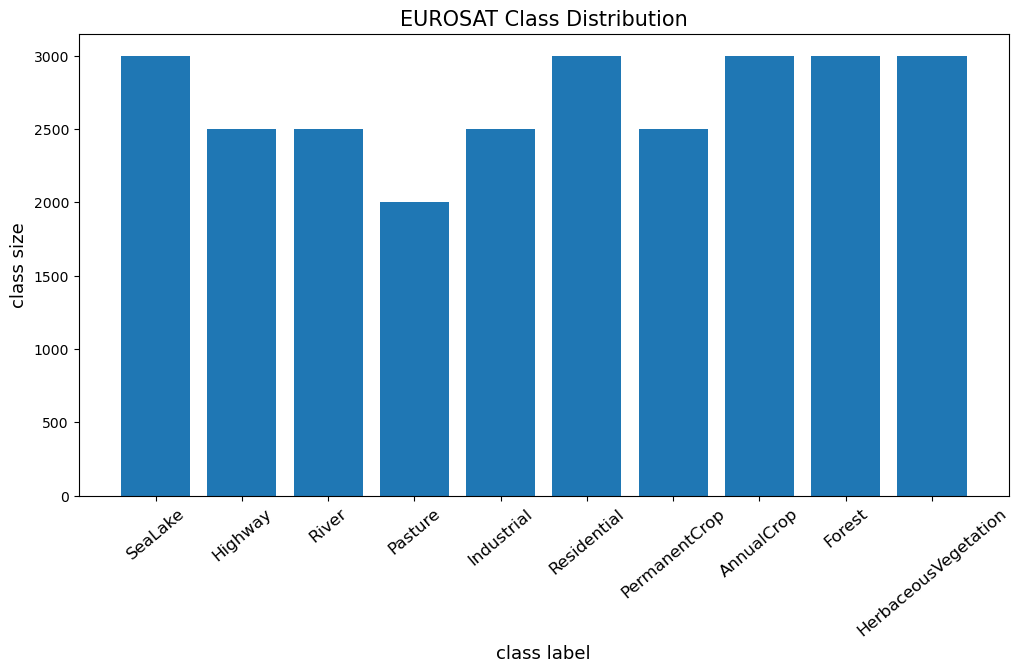

In [3]:
# plot class distributions of whole dataset as bar plot ( in order to avoid confusion )
counts = {l: len(os.listdir(os.path.join(DATASET, l))) for l in LABELS}
plt.figure(figsize=(12, 6))

plt.bar(range(len(counts)), list(counts.values()), align='center')
plt.xticks(range(len(counts)), list(counts.keys()), fontsize=12, rotation=40)
plt.xlabel('class label', fontsize=13)
plt.ylabel('class size', fontsize=13)
plt.title('EUROSAT Class Distribution', fontsize=15);

The dataset is split into 10 classes of land cover. Each class varies in size, so I'll have to stratify later on when splitting the data into training, testing and validation sets. 

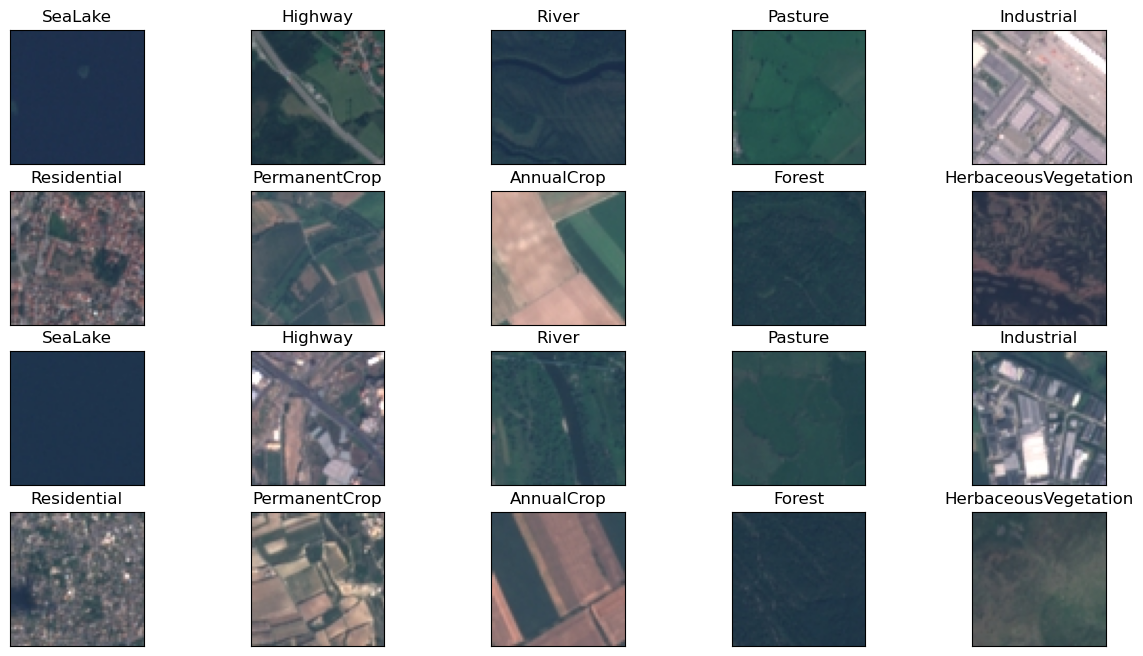

In [4]:
img_paths = [os.path.join(DATASET, l, f'{l}_1000.jpg') for l in LABELS]

img_paths += [os.path.join(DATASET, l, f'{l}_2000.jpg') for l in LABELS]

def plot_sat_imgs(paths):
    """
     Plot satellites images as a function of time. This is useful for visualizing the results of analyzing satellite images
     
     @param paths - paths to satellite images
    """
    plt.figure(figsize=(15, 8))
    # Plot the figure of the image.
    for i in range(20):
        plt.subplot(4, 5, i+1, xticks=[], yticks=[])
        img = PIL.Image.open(paths[i], 'r')
        plt.imshow(np.asarray(img))
        plt.title(paths[i].split('/')[-2])

plot_sat_imgs(img_paths)

Looking at the preview of the different classes, we can see some similarities and stark differences between the classes. 

Urban environments such as Highway, Residential and Industrial images all contain structures and some roadways. 

AnnualCrops and PermanentCrops both feature agricultural land cover, with straight lines dilineating different crop fields. 

Finally, HerbaceaousVegetation, Pasture, and Forests feature natural land cover; Rivers also could be categorized as natural land cover as well, but may be easier to distinguish from the other natural classes.

If we consider the content of each image, we might be able to estimate which classes might be confused for each other. For example, an image of a river might be mistaken for a highway. Or an image of a highway junction, with surrounding buildings, could be mistaken for an Industrial site. We'll have to train a classifier powerful enough to differentiate these nuances. 

Sentinel-2 satellite images could also be downloaded with 10+ additional bands. Near-Infrared Radiation bands, for example, is a band of data that is available for this dataset. NIR can be used to create an index, visualising the radiation that is present (or not present) in a picture. This dataset does not contain the NIR wavelength bands, so this option will not be explored. But it's worth pointing out that this classification task could be addressed in another way using NIR data. 

# II. Preprocessing

I'd like to evaluate the performance of the model later on after training, so I'll perform a stratified shuffle-split using Scikit-learn to maintain class proportions. 30% of the dataset will be held for evaluation purposes. I'll be loading my data into the Keras model using the ImageDataGenerator class. I'll need the images to be in their own respective land cover directories. 

After splitting the dataset, I'll create some image augmentations using the generator and also denote a subset of the training data to be used as validation data during training. 

In [5]:
#The code snippet is creating and initializing directories for training and testing data. It is creating two main directories: `TRAIN_DIR` and `TEST_DIR`. If these directories do not already exist, the code creates them using the `os.mkdir()` function.
# Creates and initializes non - existent skeleton directories. This is called by generate. py to generate code
TRAIN_DIR = '../working/training'
TEST_DIR = '../working/testing'
BATCH_SIZE = 64
NUM_CLASSES=len(LABELS)
INPUT_SHAPE = (64, 64, 3)
CLASS_MODE = 'categorical'

# create training and testing directories
for path in (TRAIN_DIR, TEST_DIR):
    if not os.path.exists(path):
        os.mkdir(path)

# create class label subdirectories in train and test
for l in LABELS:
    
    if not os.path.exists(os.path.join(TRAIN_DIR, l)):
        os.mkdir(os.path.join(TRAIN_DIR, l))

    if not os.path.exists(os.path.join(TEST_DIR, l)):
        os.mkdir(os.path.join(TEST_DIR, l))

In [6]:
# This is the code for the genetic algorithm. It maps each image to its class label
# map each image path to their class label in 'data'
data = {}

for l in LABELS:
    for img in os.listdir(f'{DATASET}/{l}'):
        data[os.path.join(DATASET, l, img)] = l

X = pd.Series(list(data.keys()))
y = pd.get_dummies(pd.Series(data.values()))

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2) #, random_state=69

# split the list of image paths
for train_idx, test_idx in split.split(X, y):

    train_paths = X[train_idx]
    test_paths = X[test_idx]

    # define a new path for each image depending on training or testing
    new_train_paths = [re.sub('/kaggle/input/eurosat-rgb/2750', '../working/training', i) for i in train_paths]
    new_test_paths = [re.sub('/kaggle/input/eurosat-rgb/2750', '../working/testing', i) for i in test_paths]

    train_path_map = list((zip(train_paths, new_train_paths)))
    test_path_map = list((zip(test_paths, new_test_paths)))

    # move the files
    print("moving training files..")
    for i in tq.tqdm(train_path_map, position=0, leave=True):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

    print("moving testing files..")
    for i in tq.tqdm(test_path_map):
        if not os.path.exists(i[1]):
            if not os.path.exists(re.sub('training', 'testing', i[1])):
                shutil.copy(i[0], i[1])

moving training files..


  0%|          | 0/21600 [00:00<?, ?it/s]

moving testing files..


  0%|          | 0/5400 [00:00<?, ?it/s]

In [7]:
# The code is creating two instances of the `ImageDataGenerator` class from the Keras library. These generators are used for data augmentation, which is a technique used to increase the size of the training dataset by applying various transformations to the existing images.
# Create a ImageDataGenerator which can be used for data augmentation. This is a helper function to create a train and test generator

train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=160,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip = True
)

train_generator = train_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True,
)

# test generator for evaluation purposes with no augmentations, just rescaling
test_gen = ImageDataGenerator(
    rescale=1./255,
)

test_generator = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=BATCH_SIZE,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=False,
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [8]:
print(train_generator.class_indices)

{'AnnualCrop': 0, 'Forest': 1, 'HerbaceousVegetation': 2, 'Highway': 3, 'Industrial': 4, 'Pasture': 5, 'PermanentCrop': 6, 'Residential': 7, 'River': 8, 'SeaLake': 9}


In [9]:
np.save('class_indices', train_generator.class_indices)

# III. Machine Learning for Image Classification

First, we will see how a machine learning model performs by directly feeding it the whole image pixels (64x64x3 = 12288). From our 80-20 split on the 27000 samples dataset the training data is of size 21600 and test data is of size 5400. Now, here I will use some trick to utilize keras ImageDataGenerator such that we can obtain the image dataset as a numpy array which can be used by a machine learning model for training and testing. 

Now, here I will test Random Forest Classifier. First by using the direct implementation provided by scikit-learn and other implemented from scratch. This notebook is a part of my course project because of which I have included this additional implementation from scratch. Feel free to check it out or you can skip over it if you want.


In [10]:
# This is a test of random images. We have two sets of images that are in the same directory and have different set of features
#`N_EPOCHS = 70` is a variable that represents the number of epochs, which is the number of times the entire dataset will be passed through the neural network during training.
# In this case, the value is set to 70, meaning the dataset will be passed through the network 70 times during training.
N_EPOCHS = 35


# Using image data generator api in keras for making image dataset 
rf_gen = ImageDataGenerator(rescale=1./255)

rf_train_generator = rf_gen.flow_from_directory(
    directory=TRAIN_DIR,
    target_size=(64, 64),
    batch_size=21600, # by using batch_size as training data size we can extract data from this iterator
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True, 
)

rf_test_generator = rf_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=5400,
    class_mode=CLASS_MODE,
    color_mode='rgb',
    shuffle=True, #False
)

Found 21600 images belonging to 10 classes.
Found 5400 images belonging to 10 classes.


In [11]:
train = rf_train_generator.next()
X_train = train[0].reshape(21600, 12288)
y_train = train[1]

test = rf_test_generator.next()
X_test = test[0].reshape(5400, 12288)
y_test = test[1]

### 1. Random Forest Scikit-Learn Implementation

In [12]:
# Creating mini batches of training data as training on whole data is difficult
ids_1 = np.random.choice(len(X_train), size=21600, replace=False)
X_train_mini_1 = X_train[ids_1]
y_train_mini_1 = rf_train_generator.classes[ids_1]

In [13]:
rf_clf = ensemble.RandomForestClassifier(n_estimators=100, n_jobs=-1) 
rf_clf.fit(X_train_mini_1, y_train_mini_1)
y_pred = rf_clf.predict(X_test)
acc = accuracy_score(y_pred, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(acc))

Accuracy Score: 0.09741


### 2. Random Forest Implementation from scratch
The dataset size is quite large (21600x12288).With scikit-learn's implementation of Random Forest we were barely able to train the model. The implementation from scratch is however not that efficient so we will only provide it with a fraction of training data. Still it can be observed that it produces reasonable accuracy considering for a 10 class classification problem a random guessing approach gives accuracy of 11%

In [14]:
#The code you provided contains three functions: `shuffle_in_unison`, `entropy`, and `information_gain`.
def shuffle_in_unison(a, b):
    """
     Shuffles two lists of equal length and keeps corresponding elements in the same index.
     
     @param a - First list to shuffle. Must be sorted in increasing order.
     @param b - Second list to shuffle. Must be sorted in increasing order
    """
    """ Shuffles two lists of equal length and keeps corresponding elements in the same index. """
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)


def entropy(Y):
    """
    Computes entropy of a group of random samples. This is a measure of the uncertanty of a random sample from a group.
    
    @param Y - A list of numbers. Each number is a group of random samples.
    
    @return The entropy of the group of random samples as a float
    """
    """ In information theory, entropy is a measure of the uncertanty of a random sample from a group. """
    
    distribution = Counter(Y)
    s = 0.0
    total = len(Y)
    # Calculate the probability of the distribution.
    for y, num_y in distribution.items():
        probability_y = (num_y/total)
        s += (probability_y)*np.log(probability_y)
    return -s


def information_gain(y, y_true, y_false):
    """
     Calculates information gain of two groups. It is the difference between the entropy of the data divided into two groups and the ratio of the two groups is calculated.
     
     @param y - [ n_samples ] True labels. Shape : [ n_samples ]
     @param y_true - [ n_samples ] True labels. Shape : [ n_samples ]
     @param y_false - [ n_samples ] False labels. Shape : [ n_samples ]
     
     @return [ n_samples ] Information gain of y_true and y_false
    """
    """ The reduction in entropy from splitting data into two groups. """
    return entropy(y) - (entropy(y_true)*len(y_true) + entropy(y_false)*len(y_false))/len(y)

In [15]:
# Implementing a Decision Tree Classifier

class DecisionTreeClassifier(object):
    """ A decision tree classifier.
    A decision tree is a structure in which each node represents a binary
    conditional decision on a specific feature, each branch represents the
    outcome of the decision, and each leaf node represents a final
    classification.
    """

    def __init__(self, max_features=lambda x: x, max_depth=10,
                    min_samples_split=2):
        """
        Args:
            max_features: A function that controls the number of features to
                randomly consider at each split. The argument will be the number
                of features in the data.
            max_depth: The maximum number of levels the tree can grow downwards
                before forcefully becoming a leaf.
            min_samples_split: The minimum number of samples needed at a node to
                justify a new node split.
        """

        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split


    def fit(self, X, y):
        """ Builds the tree by chooseing decision rules for each node based on
        the data. """

        n_features = X.shape[1]
        n_sub_features = int(self.max_features(n_features))
        feature_indices = random.sample(range(n_features), n_sub_features)
        
        self.trunk = self.build_tree(X, y, feature_indices, 0)


    def predict(self, X):
        """ Predict the class of each sample in X. """

        num_samples = X.shape[0]
        y = np.empty(num_samples)
        for j in tq.tqdm(range(num_samples)):
            node = self.trunk

            while isinstance(node, Node):
                if X[j][node.feature_index] <= node.threshold:
                    node = node.branch_true
                else:
                    node = node.branch_false
            y[j] = node

        return y


    def build_tree(self, X, y, feature_indices, depth):
        """ Recursivly builds a decision tree. """

        if (
            depth is self.max_depth
            or len(y) < self.min_samples_split
            or entropy(y) == 0
        ):
            return mode(y)[0][0]

        feature_index, threshold = find_split(X, y, feature_indices)

        X_true, y_true, X_false, y_false = split(X, y, feature_index, threshold)
        if y_true.shape[0] == 0 or y_false.shape[0] == 0:
            return mode(y)[0][0]

        branch_true = self.build_tree(X_true, y_true, feature_indices, depth + 1)
        branch_false = self.build_tree(X_false, y_false, feature_indices, depth + 1)

        return Node(feature_index, threshold, branch_true, branch_false)


def find_split(X, y, feature_indices):
    """ Returns the best split rule for a tree node. """

    num_features = X.shape[1]

    best_gain = 0
    best_feature_index = 0
    best_threshold = 0
    for feature_index in feature_indices:
        values = sorted(set(X[:, feature_index])) ### better way

        for j in range(len(values) - 1):
            threshold = (values[j] + values[j+1])/2
            X_true, y_true, X_false, y_false = split(X, y, feature_index, threshold)
            gain = information_gain(y, y_true, y_false)

            if gain > best_gain:
                best_gain = gain
                best_feature_index = feature_index
                best_threshold = threshold

    return best_feature_index, best_threshold


class Node(object):
    """ A node in a decision tree with the binary condition xi <= t. """

    def __init__(self, feature_index, threshold, branch_true, branch_false):
        self.feature_index = feature_index
        self.threshold = threshold
        self.branch_true = branch_true
        self.branch_false = branch_false


def split(X, y, feature_index, threshold):
    """ Splits X and y based on the binary condition xi <= threshold. """

    X_true = []
    y_true = []
    X_false = []
    y_false = []

    for j in range(len(y)):
        if X[j][feature_index] <= threshold:
            X_true.append(X[j])
            y_true.append(y[j])
        else:
            X_false.append(X[j])
            y_false.append(y[j])

    X_true = np.array(X_true)
    y_true = np.array(y_true)
    X_false = np.array(X_false)
    y_false = np.array(y_false)

    return X_true, y_true, X_false, y_false

In [16]:
# Implementing Random Forest Clasifier

class RandomForestClassifier(object):
    """ A random forest classifier.
    A random forest is a collection of decision trees that vote on a
    classification decision. Each tree is trained with a subset of the data and
    features.
    """

    def __init__(self, n_estimators=32, max_features=np.sqrt, max_depth=10,
        min_samples_split=2, bootstrap=0.9):
        """
        Args:
            n_estimators: The number of decision trees in the forest.
            max_features: Controls the number of features to randomly consider
                at each split.
            max_depth: The maximum number of levels that the tree can grow
                downwards before forcefully becoming a leaf.
            min_samples_split: The minimum number of samples needed at a node to
                justify a new node split.
            bootstrap: The fraction of randomly choosen data to fit each tree on.
        """
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.bootstrap = bootstrap
        self.n_jobs = -1
        self.forest = []


    def fit(self, X, y):
        """ Creates a forest of decision trees using a random subset of data and
            features. """
        self.forest = []
        n_samples = len(y)
        n_sub_samples = round(n_samples*self.bootstrap)

        for _ in tq.tqdm(range(self.n_estimators)):
            shuffle_in_unison(X, y)
            X_subset = X[:n_sub_samples]
            y_subset = y[:n_sub_samples]

            tree = DecisionTreeClassifier(self.max_features, self.max_depth,
                                            self.min_samples_split)
            tree.fit(X_subset, y_subset)
            self.forest.append(tree)


    def predict(self, X):
        """ Predict the class of each sample in X. """
        n_samples = X.shape[0]
        n_trees = len(self.forest)
        predictions = np.empty([n_trees, n_samples])
        for i in range(n_trees):
            predictions[i] = self.forest[i].predict(X)

        return mode(predictions)[0][0]


    def score(self, X, y):
        """ Return the accuracy of the prediction of X compared to y. """
        y_predict = self.predict(X)
        n_samples = len(y)
        correct = 0
        for i in range(n_samples):
            if y_predict[i] == y[i]:
                correct = correct + 1
        return correct/n_samples

In [17]:
# Creating mini batches of training data as training on whole data is difficult
ids_2 = np.random.choice(len(X_train), size=2160, replace=False)
X_train_mini_2 = X_train[ids_2]
y_train_mini_2 = rf_train_generator.classes[ids_2]

In [18]:
%%time

forest = RandomForestClassifier(n_estimators=2)
forest.fit(X_train_mini_2, y_train_mini_2)

  0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 1h 14min 38s, sys: 18min 30s, total: 1h 33min 9s
Wall time: 1h 33min 22s


In [19]:
accuracy = forest.score(X_test, rf_test_generator.classes)
print("Accuracy Score: {0:.4}".format(accuracy))

  0%|          | 0/5400 [00:00<?, ?it/s]

  0%|          | 0/5400 [00:00<?, ?it/s]

Accuracy Score: 0.102


# IV. Deep Learning For Image Classification

Deep Learning has highly influenced the field of computer vision when Convolutional Neural Networks (CNN) models were used in tasks like image classification, object detection, facial recognition etc. As discussed by authors of EuroSAT paper many deep learning models outperform the traditional non deep learning methods by a large margin. 

In this section we will train many state of the art architectures which performed well on the ILSVRC challenge. The authors achieved an accuracy of 98.57% using a fine tuned ResNet50 model. Here, I will try to employ a similar strategy for training the models where initially the CNN part of the model will be frozen with imagenet weights and dense layers will be trained with a high learning rate of 0.01 and later we will train the whole model end-to-end i.e. fine tune by keeping a small learning rate between 0.001 to 0.0001

Before we start here is a list of CNN models which we will train:
1. ResNet50
2. ResNet50V2
3. ResNet152V2
3. VGG16
4. VGG19
5. Efficientnet version 2
6. DenseNet201


In [20]:
# Sets up the graph structure for TensorFlow. This is a hack to avoid having to re - initialize the graph every time
# The code block is checking if there are any available GPUs (graphics processing units) for TensorFlow to use. 
# If there are GPUs available, it restricts TensorFlow to only use the first GPU. 
# It then retrieves the list of logical GPUs and prints the number of physical and logical GPUs found. 
# If there are no GPUs available or if there is an error, it prints an error message. 
# Finally, it sets the soft device placement to True, which allows TensorFlow to automatically 
# choose the device (CPU or GPU) to execute operations on.
if gpus := tf.config.experimental.list_physical_devices('GPU'):
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


In [21]:
# The below code defines several functions related to compiling and training CNN models, 
# as well as evaluating and visualizing the results.
# Note that for different CNN models we are using different setup of dense layers
def compile_model(cnn_base, input_shape, n_classes, optimizer, fine_tune=None):
    """
    Compile and return a Keras model. 
    
    @param cnn_base - Name of the cnn to compile
    @param input_shape - Shape of the input to the model
    @param n_classes - Number of classes in the model ( int )
    @param optimizer - Optimizer used to compile the model ( callable )
    @param fine_tune - Fine tune for the model ( callable )
    
    @return Compiled Keras model ( keras model ) or None if compilation
    """
    if cnn_base in ['ResNet50', 'ResNet50V2', 'ResNet152V2']:
        if cnn_base == 'ResNet50':
            conv_base = ResNet50(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'ResNet50V2':
            conv_base = ResNet50V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        else:
            conv_base = ResNet152V2(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = _extracted_from_compile_model_26(conv_base)
    elif cnn_base in ['efficientnet_v2', 'DenseNet']:
        if cnn_base == 'DenseNet':
            conv_base = DenseNet201(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        elif cnn_base == 'efficientnet_v2':
            conv_base = efficientnet_v2.EfficientNetV2B3(include_top=False,
                                 weights='imagenet', 
                                 input_shape=input_shape)
        top_model = _extracted_from_compile_model_26(conv_base)
    elif cnn_base in ['VGG16', 'VGG19']:
        if cnn_base == 'VGG16':
            conv_base = VGG16(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        else:
            conv_base = VGG19(include_top=False,
                              weights='imagenet', 
                              input_shape=input_shape)
        top_model = _extracted_from_compile_model_26(conv_base)
        top_model = Dense(2048, activation='relu')(top_model)
        top_model = Dropout(0.2)(top_model)


    output_layer = Dense(n_classes, activation='softmax')(top_model)

    model = Model(inputs=conv_base.input, outputs=output_layer)

    # if the given fine_tune is an int then set layer. trainable to True
    if type(fine_tune) == int:
        # Set trainingable to true.
        for layer in conv_base.layers[fine_tune:]:
            layer.trainable = True
    else:
        # Set trainingable to False.
        for layer in conv_base.layers:
            layer.trainable = False

    model.compile(optimizer=optimizer, loss='categorical_crossentropy',
                 metrics=['categorical_accuracy'])

    return model


# TODO Rename this here and in `compile_model`
def _extracted_from_compile_model_26(conv_base):
    result = conv_base.output
    result = Flatten()(result)
    result = Dense(2048, activation='relu')(result)
    result = Dropout(0.2)(result)
           

    return result



def plot_history(history):
    """
    Plot history. This is a convenience function to make it easier to visualize the accuracy and loss of a model
    
    @param history - A : class : ` History `
    """
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(10, 5))
    _extracted_from_plot_history_13(1, acc, val_acc, 'accuracy')
    _extracted_from_plot_history_13(2, loss, val_loss, 'loss')
    plt.show();


# TODO Rename this here and in `plot_history`
def _extracted_from_plot_history_13(arg0, arg1, arg2, arg3):
    plt.subplot(1, 2, arg0)
    plt.plot(arg1)
    plt.plot(arg2)
    plt.ylabel(arg3)
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')

def display_results(y_true, y_preds, class_labels):
    """
    Display results and confusion matrix. This function is called at the end of training and should not be called directly
    
    @param y_true - Array - like of shape = [ n_samples ] Ground truth ( correct ) target values.
    @param y_preds - Array - like of shape = [ n_samples ] Estimated targets as returned by a classifier.
    @param class_labels - List of strings. Label of each class.
    
    @return A tuple containing two DataFrame objects : precision_recall_fscore_support ( pandas DataFrame ) and f -
    """
    
    results = pd.DataFrame(precision_recall_fscore_support(y_true, y_preds),
                          columns=class_labels).T
    results.rename(columns={0: 'Precision',
                           1: 'Recall',
                           2: 'F-Score',
                           3: 'Support'}, inplace=True)
    
    conf_mat = pd.DataFrame(confusion_matrix(y_true, y_preds), 
                            columns=class_labels,
                            index=class_labels)    
    f2 = fbeta_score(y_true, y_preds, beta=2, average='micro')
    accuracy = accuracy_score(y_true, y_preds)
    print(f"Accuracy: {accuracy}")
    print(f"Global F2 Score: {f2}")    
    return results, conf_mat

def plot_predictions(y_true, y_preds, test_generator, class_indices):
    """
    Plot predictions for each class. This is a function to be used in tests
    
    @param y_true - List of labels for true classes
    @param y_preds - List of labels for predicted classes
    @param test_generator - Generator of test data from which predictions are plotted
    @param class_indices - List of class indices for which predictions are
    """
    # Generate a random sample of the test generator.
    fig = plt.figure(figsize=(20, 10))
    for i, idx in enumerate(np.random.choice(test_generator.samples, size=20, replace=False)):
        ax = fig.add_subplot(4, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(np.squeeze(test_generator[idx]))
        pred_idx = np.argmax(y_preds[idx])
        true_idx = y_true[idx]

        plt.tight_layout()
        ax.set_title(
            f"{class_indices[pred_idx]}\n({class_indices[true_idx]})",
            color=("green" if pred_idx == true_idx else "red"),
        )    

In [22]:
# This is the function that generates the training and testing set of model checkpoint and gradient
N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

## 4.1 ResNet50 Model

In [23]:
gc.collect()

resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
#resnet50_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


94765736/94765736 [==============================] - 4s 0us/step


In [24]:
# This is the code for the algorithm. We're going to have a bunch of samples in the train and test set but it's pretty straightforward
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [25]:
%%time
# This is the function that does the training and testing of the resnet50 and the same action for below functions

# First Pretraining the dense layer
resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,
                            workers=-1,
                            use_multiprocessing=True,)

<timed exec>:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/35
337/337 [==============================] - ETA: 0s - loss: 2.4423 - categorical_accuracy: 0.1979
Epoch 1: val_categorical_accuracy improved from -inf to 0.26302, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 53s 135ms/step - loss: 2.4423 - categorical_accuracy: 0.1979 - val_loss: 1.8250 - val_categorical_accuracy: 0.2630
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 2.0232 - categorical_accuracy: 0.2262
Epoch 2: val_categorical_accuracy improved from 0.26302 to 0.31231, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 47s 141ms/step - loss: 2.0232 - categorical_accuracy: 0.2262 - val_loss: 1.8338 - val_categorical_accuracy: 0.3123
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 2.0152 - categorical_accuracy: 0.2416
Epoch 3: val_categorical_accuracy did not improve from 0.31231
337/337 [==============================] - 42s 125ms/step - lo

In [26]:
%%time
# re-train whole network end2end 
resnet50_model = compile_model('ResNet50', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50_history = resnet50_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


<timed exec>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


337/337 [==============================] - ETA: 0s - loss: 1.3162 - categorical_accuracy: 0.7029
Epoch 1: val_categorical_accuracy did not improve from 0.32068
337/337 [==============================] - 57s 146ms/step - loss: 1.3162 - categorical_accuracy: 0.7029 - val_loss: 36.2674 - val_categorical_accuracy: 0.0632 - lr: 1.0000e-04
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 0.5014 - categorical_accuracy: 0.8350
Epoch 2: val_categorical_accuracy did not improve from 0.32068
337/337 [==============================] - 47s 140ms/step - loss: 0.5014 - categorical_accuracy: 0.8350 - val_loss: 14.9740 - val_categorical_accuracy: 0.1453 - lr: 1.0000e-04
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 0.4079 - categorical_accuracy: 0.8671
Epoch 3: val_categorical_accuracy improved from 0.32068 to 0.64453, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 49s 144ms/step - loss: 0.4079 - categorical_acc

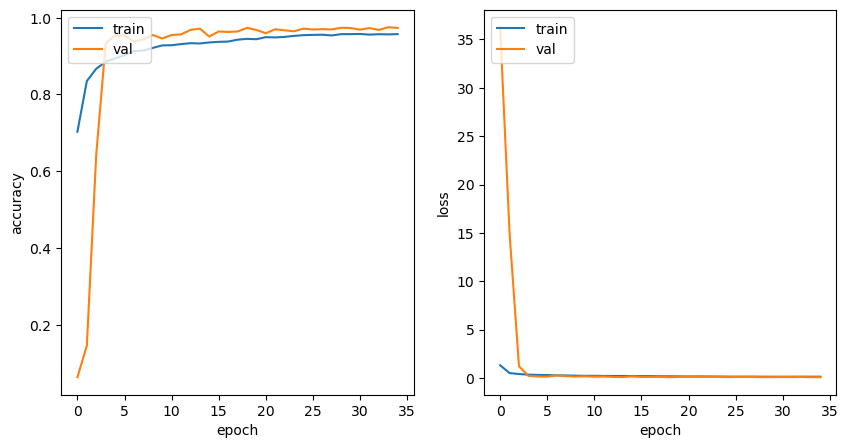

In [27]:
plot_history(resnet50_history)

In [28]:
resnet50_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = {v: k for k,v in class_indices.items()}

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=True, #False
)

predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/tmp/ipykernel_22/1803897179.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = resnet50_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.10222222222222223
Global F2 Score: 0.10222222222222223


,Precision,Recall,F-Score,Support
AnnualCrop,0.101836,0.101667,0.101751,600.0
Forest,0.108239,0.111667,0.109926,600.0
HerbaceousVegetation,0.105705,0.105000,0.105351,600.0
Highway,0.094758,0.094000,0.094378,500.0
Industrial,0.096970,0.096000,0.096482,500.0
Pasture,0.095607,0.092500,0.094028,400.0
PermanentCrop,0.075248,0.076000,0.075622,500.0
Residential,0.116393,0.118333,0.117355,600.0
River,0.091816,0.092000,0.091908,500.0
SeaLake,0.125000,0.123333,0.124161,600.0


In [29]:
# Save the model and the weights
resnet50_model.save('../working/ResNet50_eurosat.h5')

## 4.2 ResNet50V2 Model

In [30]:
gc.collect()

resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
#resnet50V2_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


94668760/94668760 [==============================] - 6s 0us/step


In [31]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [32]:
# First Pretraining the dense layer
resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


/tmp/ipykernel_22/1078985022.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet50V2_history = resnet50V2_model.fit_generator(train_generator,


337/337 [==============================] - ETA: 0s - loss: 2.2939 - categorical_accuracy: 0.5415
Epoch 1: val_categorical_accuracy improved from -inf to 0.69066, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 49s 137ms/step - loss: 2.2939 - categorical_accuracy: 0.5415 - val_loss: 1.1098 - val_categorical_accuracy: 0.6907
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.4002 - categorical_accuracy: 0.5688
Epoch 2: val_categorical_accuracy did not improve from 0.69066
337/337 [==============================] - 42s 126ms/step - loss: 1.4002 - categorical_accuracy: 0.5688 - val_loss: 1.1905 - val_categorical_accuracy: 0.6743
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 1.3322 - categorical_accuracy: 0.5835
Epoch 3: val_categorical_accuracy improved from 0.69066 to 0.69736, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 43s 129ms/step - loss: 1.3322 

In [33]:
# re-train whole network end2end 
resnet50V2_model = compile_model('ResNet50V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet50V2_history = resnet50V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


/tmp/ipykernel_22/3406315233.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  resnet50V2_history = resnet50V2_model.fit_generator(train_generator,


337/337 [==============================] - ETA: 0s - loss: 1.7776 - categorical_accuracy: 0.4632
Epoch 1: val_categorical_accuracy did not improve from 0.77083
337/337 [==============================] - 54s 143ms/step - loss: 1.7776 - categorical_accuracy: 0.4632 - val_loss: 1.1800 - val_categorical_accuracy: 0.6278 - lr: 1.0000e-04
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.2196 - categorical_accuracy: 0.6046
Epoch 2: val_categorical_accuracy did not improve from 0.77083
337/337 [==============================] - 48s 141ms/step - loss: 1.2196 - categorical_accuracy: 0.6046 - val_loss: 0.7888 - val_categorical_accuracy: 0.7515 - lr: 1.0000e-04
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 0.9907 - categorical_accuracy: 0.6851
Epoch 3: val_categorical_accuracy did not improve from 0.77083
337/337 [==============================] - 46s 138ms/step - loss: 0.9907 - categorical_accuracy: 0.6851 - val_loss: 0.7952 - val_categorical_accurac

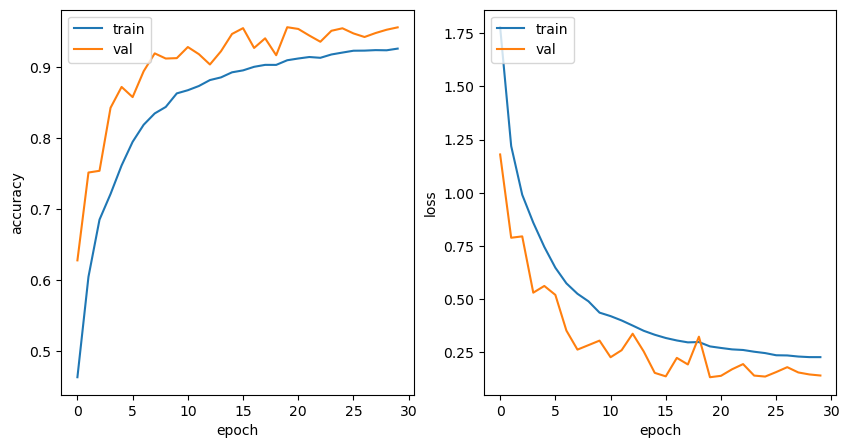

In [34]:
plot_history(resnet50V2_history)

In [35]:
resnet50V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = {v: k for k,v in class_indices.items()}

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=True, #False
)

predictions = resnet50V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/tmp/ipykernel_22/2735991622.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = resnet50V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.10759259259259259
Global F2 Score: 0.10759259259259259


,Precision,Recall,F-Score,Support
AnnualCrop,0.101806,0.103333,0.102564,600.0
Forest,0.125203,0.128333,0.126749,600.0
HerbaceousVegetation,0.126984,0.120000,0.123393,600.0
Highway,0.093204,0.096000,0.094581,500.0
Industrial,0.094949,0.094000,0.094472,500.0
Pasture,0.087500,0.087500,0.087500,400.0
PermanentCrop,0.105058,0.108000,0.106509,500.0
Residential,0.119741,0.123333,0.121511,600.0
River,0.083164,0.082000,0.082578,500.0
SeaLake,0.123693,0.118333,0.120954,600.0


In [36]:
# Save the model and the weights
resnet50V2_model.save('../working/ResNet50V2_eurosat.h5')

## 4.3 ResNet152V2 Model

In [37]:
gc.collect()

resnet152V2_model = compile_model('ResNet152V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
#resnet152V2_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


234545216/234545216 [==============================] - 11s 0us/step


In [38]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [39]:
%%time

# First Pretraining the dense layer
resnet152V2_history = resnet152V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

<timed exec>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/35
337/337 [==============================] - ETA: 0s - loss: 2.0307 - categorical_accuracy: 0.5186
Epoch 1: val_categorical_accuracy improved from -inf to 0.63597, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 62s 158ms/step - loss: 2.0307 - categorical_accuracy: 0.5186 - val_loss: 1.4121 - val_categorical_accuracy: 0.6360
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.5417 - categorical_accuracy: 0.5584
Epoch 2: val_categorical_accuracy improved from 0.63597 to 0.64416, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 53s 156ms/step - loss: 1.5417 - categorical_accuracy: 0.5584 - val_loss: 1.1835 - val_categorical_accuracy: 0.6442
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 1.4381 - categorical_accuracy: 0.5646
Epoch 3: val_categorical_accuracy improved from 0.64416 to 0.68025, saving model to ../working/model.weights.best.hdf5
337/33

In [40]:
%%time

# re-train whole network end2end 
resnet152V2_model = compile_model('ResNet152V2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

resnet152V2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

resnet152V2_history = resnet152V2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


<timed exec>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


337/337 [==============================] - ETA: 0s - loss: 1.9810 - categorical_accuracy: 0.4351
Epoch 1: val_categorical_accuracy did not improve from 0.74498
337/337 [==============================] - 81s 190ms/step - loss: 1.9810 - categorical_accuracy: 0.4351 - val_loss: 1.5051 - val_categorical_accuracy: 0.5740 - lr: 1.0000e-04
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.2323 - categorical_accuracy: 0.6089
Epoch 2: val_categorical_accuracy improved from 0.74498 to 0.78888, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 64s 190ms/step - loss: 1.2323 - categorical_accuracy: 0.6089 - val_loss: 0.8235 - val_categorical_accuracy: 0.7889 - lr: 1.0000e-04
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 1.0188 - categorical_accuracy: 0.6739
Epoch 3: val_categorical_accuracy improved from 0.78888 to 0.82385, saving model to ../working/model.weights.best.hdf5
337/337 [===========================

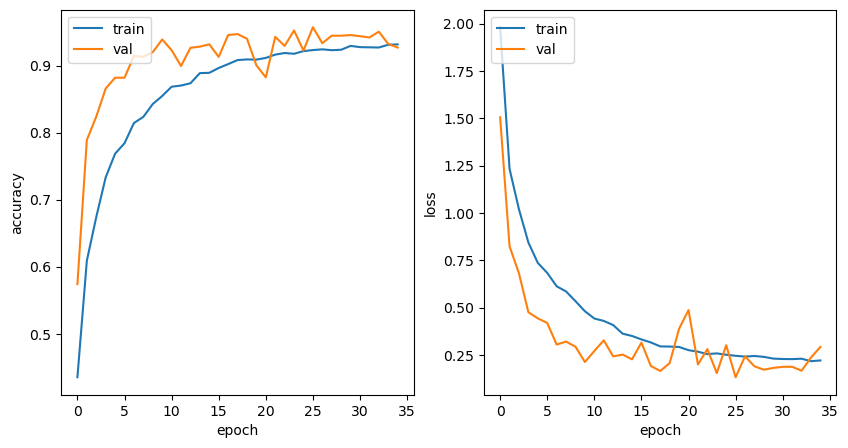

In [41]:
plot_history(resnet152V2_history)

In [42]:
resnet152V2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = {v: k for k,v in class_indices.items()}

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=True, #False
)

predictions = resnet152V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/tmp/ipykernel_22/423813051.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = resnet152V2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.10574074074074075
Global F2 Score: 0.10574074074074075


,Precision,Recall,F-Score,Support
AnnualCrop,0.092869,0.093333,0.093101,600.0
Forest,0.121451,0.128333,0.124797,600.0
HerbaceousVegetation,0.118966,0.115000,0.116949,600.0
Highway,0.105769,0.110000,0.107843,500.0
Industrial,0.096436,0.092000,0.094166,500.0
Pasture,0.076712,0.070000,0.073203,400.0
PermanentCrop,0.105159,0.106000,0.105578,500.0
Residential,0.112342,0.118333,0.115260,600.0
River,0.087755,0.086000,0.086869,500.0
SeaLake,0.122689,0.121667,0.122176,600.0


In [43]:
# Save the model and the weights
resnet152V2_model.save('../working/ResNet152V2_eurosat.h5')

## 4.4 VGG16 Model

In [44]:
gc.collect()

vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
#vgg16_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


58889256/58889256 [==============================] - 3s 0us/step


In [45]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [46]:
%%time

train_generator.reset()
# First Pretraining the dense layer
vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


<timed exec>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


337/337 [==============================] - ETA: 0s - loss: 2.2762 - categorical_accuracy: 0.4480
Epoch 1: val_categorical_accuracy improved from -inf to 0.55580, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 44s 128ms/step - loss: 2.2762 - categorical_accuracy: 0.4480 - val_loss: 1.2744 - val_categorical_accuracy: 0.5558
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.3601 - categorical_accuracy: 0.5198
Epoch 2: val_categorical_accuracy improved from 0.55580 to 0.57961, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 44s 131ms/step - loss: 1.3601 - categorical_accuracy: 0.5198 - val_loss: 1.1599 - val_categorical_accuracy: 0.5796
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 1.2937 - categorical_accuracy: 0.5429
Epoch 3: val_categorical_accuracy improved from 0.57961 to 0.65997, saving model to ../working/model.weights.best.hdf5
337/337 [========

In [47]:
%%time

# re-train whole network end2end 
vgg16_model = compile_model('VGG16', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg16_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg16_history = vgg16_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


<timed exec>:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


337/337 [==============================] - ETA: 0s - loss: 2.8642 - categorical_accuracy: 0.1022
Epoch 1: val_categorical_accuracy did not improve from 0.71968
337/337 [==============================] - 46s 131ms/step - loss: 2.8642 - categorical_accuracy: 0.1022 - val_loss: 2.7084 - val_categorical_accuracy: 0.0930 - lr: 1.0000e-04
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 2.6295 - categorical_accuracy: 0.0975
Epoch 2: val_categorical_accuracy did not improve from 0.71968
337/337 [==============================] - 47s 140ms/step - loss: 2.6295 - categorical_accuracy: 0.0975 - val_loss: 2.5162 - val_categorical_accuracy: 0.0930 - lr: 1.0000e-04
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 2.4795 - categorical_accuracy: 0.0977
Epoch 3: val_categorical_accuracy did not improve from 0.71968
337/337 [==============================] - 48s 142ms/step - loss: 2.4795 - categorical_accuracy: 0.0977 - val_loss: 2.4029 - val_categorical_accurac

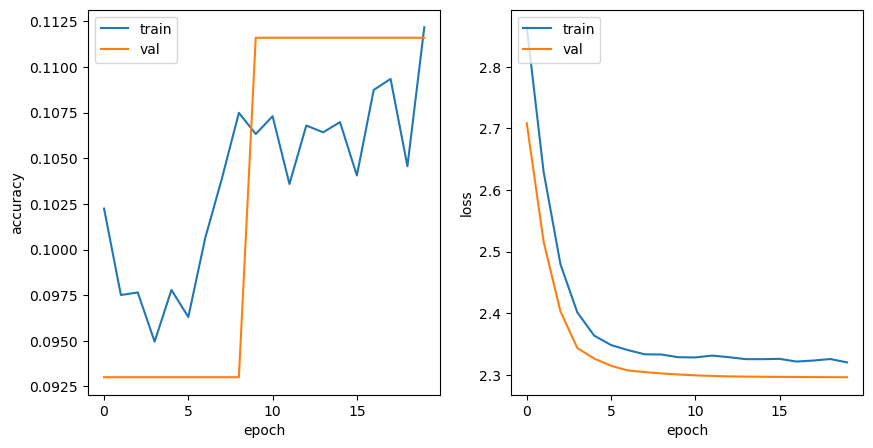

In [48]:
plot_history(vgg16_history)

In [49]:
# This is the implementation of vgg16_model. predict_generator () that takes a generator and predicts the most probable class
# The code snippet is loading the weights of a pre-trained VGG16 model from a file called 'model.weights.best.hdf5'.
vgg16_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = {v: k for k,v in class_indices.items()}

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=True, #False
)

predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/tmp/ipykernel_22/222686870.py:17: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = vgg16_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.10703703703703704
Global F2 Score: 0.10703703703703704


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
AnnualCrop,0.112040,0.111667,0.111853,600.0
Forest,0.125000,0.048333,0.069712,600.0
HerbaceousVegetation,0.127750,0.251667,0.169473,600.0
Highway,0.000000,0.000000,0.000000,500.0
Industrial,0.094662,0.344000,0.148468,500.0
Pasture,0.000000,0.000000,0.000000,400.0
PermanentCrop,0.000000,0.000000,0.000000,500.0
Residential,0.106322,0.123333,0.114198,600.0
River,0.094136,0.122000,0.106272,500.0
SeaLake,0.105727,0.040000,0.058041,600.0


In [50]:
# Save the model and the weights
vgg16_model.save('../working/vgg16_eurosat.h5')

## 4.5 VGG19 Model

In [51]:
gc.collect()

vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
#vgg19_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


80134624/80134624 [==============================] - 4s 0us/step


In [52]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [53]:
%%time

train_generator.reset()
# First Pretraining the dense layer
vgg19_history = vgg19_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


<timed exec>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


337/337 [==============================] - ETA: 0s - loss: 2.5252 - categorical_accuracy: 0.4570
Epoch 1: val_categorical_accuracy improved from -inf to 0.63002, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 43s 124ms/step - loss: 2.5252 - categorical_accuracy: 0.4570 - val_loss: 1.0915 - val_categorical_accuracy: 0.6300
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.3841 - categorical_accuracy: 0.5120
Epoch 2: val_categorical_accuracy did not improve from 0.63002
337/337 [==============================] - 45s 133ms/step - loss: 1.3841 - categorical_accuracy: 0.5120 - val_loss: 1.4399 - val_categorical_accuracy: 0.5095
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 1.3382 - categorical_accuracy: 0.5244
Epoch 3: val_categorical_accuracy improved from 0.63002 to 0.63467, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 41s 121ms/step - loss: 1.3382 

In [54]:
# re-train whole network end2end 
vgg19_model = compile_model('VGG19', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

vgg19_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

vgg19_history = vgg19_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


/tmp/ipykernel_22/1914809605.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  vgg19_history = vgg19_model.fit_generator(train_generator,


337/337 [==============================] - ETA: 0s - loss: 1.5913 - categorical_accuracy: 0.4279
Epoch 1: val_categorical_accuracy did not improve from 0.67820
337/337 [==============================] - 46s 134ms/step - loss: 1.5913 - categorical_accuracy: 0.4279 - val_loss: 1.3507 - val_categorical_accuracy: 0.5009 - lr: 1.0000e-04
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.2107 - categorical_accuracy: 0.5778
Epoch 2: val_categorical_accuracy did not improve from 0.67820
337/337 [==============================] - 50s 148ms/step - loss: 1.2107 - categorical_accuracy: 0.5778 - val_loss: 1.0400 - val_categorical_accuracy: 0.6689 - lr: 1.0000e-04
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 1.0374 - categorical_accuracy: 0.6457
Epoch 3: val_categorical_accuracy improved from 0.67820 to 0.71205, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 50s 147ms/step - loss: 1.0374 - categorical_accur

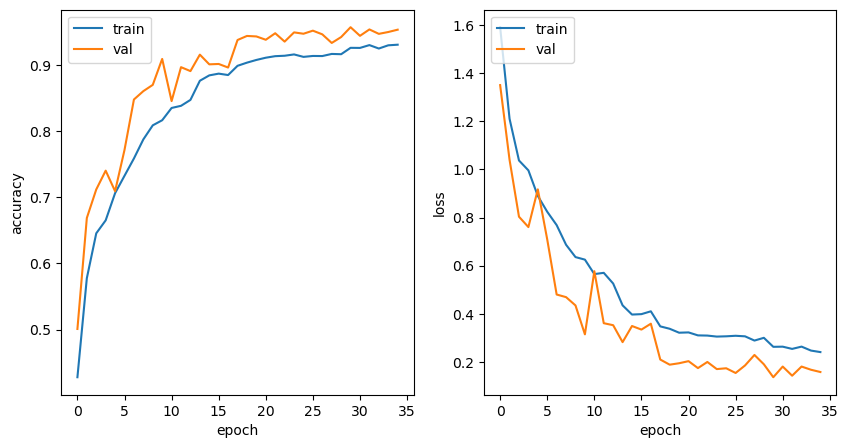

In [55]:
plot_history(vgg19_history)

In [56]:
vgg19_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = {v: k for k,v in class_indices.items()}

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=True, #False
)

predictions = vgg19_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/tmp/ipykernel_22/1501364268.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = vgg19_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.1111111111111111
Global F2 Score: 0.1111111111111111


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Precision,Recall,F-Score,Support
AnnualCrop,0.111152,1.0,0.200067,600.0
Forest,0.000000,0.0,0.000000,600.0
HerbaceousVegetation,0.000000,0.0,0.000000,600.0
Highway,0.000000,0.0,0.000000,500.0
Industrial,0.000000,0.0,0.000000,500.0
Pasture,0.000000,0.0,0.000000,400.0
PermanentCrop,0.000000,0.0,0.000000,500.0
Residential,0.000000,0.0,0.000000,600.0
River,0.000000,0.0,0.000000,500.0
SeaLake,0.000000,0.0,0.000000,600.0


In [57]:
# Save the model and the weights
vgg19_model.save('../working/vgg19_eurosat.h5')

/tmp/ipykernel_22/3683959286.py:156: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


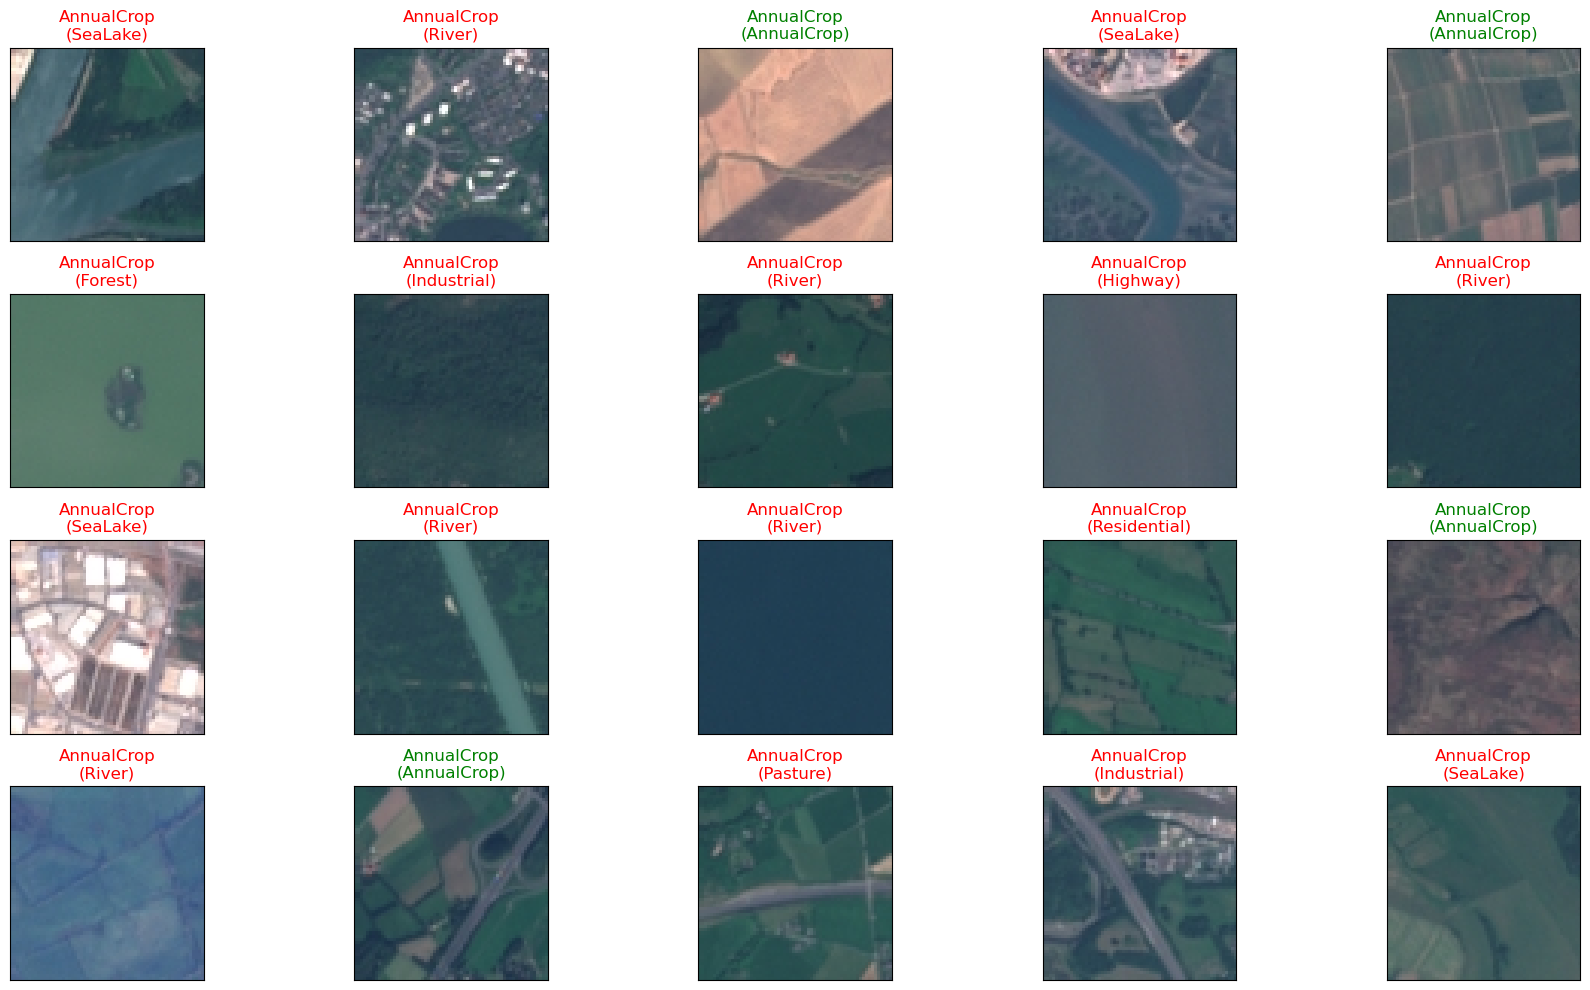

In [58]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)

## 4.6 efficientnet_v2 Model

In [59]:
gc.collect()

efficientnet_v2_model = compile_model('efficientnet_v2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
#efficientnet_v2_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


52606240/52606240 [==============================] - 3s 0us/step


In [60]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [61]:
%%time

train_generator.reset()
# First Pretraining the dense layer
efficientnet_v2_model_history = efficientnet_v2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

<timed exec>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/35


2023-07-30 02:02:04.270784: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


337/337 [==============================] - ETA: 0s - loss: 5.8015 - categorical_accuracy: 0.1082
Epoch 1: val_categorical_accuracy improved from -inf to 0.11161, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 57s 135ms/step - loss: 5.8015 - categorical_accuracy: 0.1082 - val_loss: 2.2955 - val_categorical_accuracy: 0.1116
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 2.3072 - categorical_accuracy: 0.1069
Epoch 2: val_categorical_accuracy did not improve from 0.11161
337/337 [==============================] - 47s 139ms/step - loss: 2.3072 - categorical_accuracy: 0.1069 - val_loss: 2.2953 - val_categorical_accuracy: 0.1116
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 2.3073 - categorical_accuracy: 0.1095
Epoch 3: val_categorical_accuracy did not improve from 0.11161
337/337 [==============================] - 46s 136ms/step - loss: 2.3073 - categorical_accuracy: 0.1095 - val_loss: 2.2958 - val_

In [62]:
# re-train whole network end2end 
efficientnet_v2_model = compile_model('efficientnet_v2', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

efficientnet_v2_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

efficientnet_v2_model_history = efficientnet_v2_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


/tmp/ipykernel_22/3230195549.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  efficientnet_v2_model_history = efficientnet_v2_model.fit_generator(train_generator,
2023-07-30 02:12:15.306458: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


337/337 [==============================] - ETA: 0s - loss: 11.5514 - categorical_accuracy: 0.3414
Epoch 1: val_categorical_accuracy improved from 0.11161 to 0.61551, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 71s 163ms/step - loss: 11.5514 - categorical_accuracy: 0.3414 - val_loss: 1.2594 - val_categorical_accuracy: 0.6155 - lr: 1.0000e-04
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.4927 - categorical_accuracy: 0.4848
Epoch 2: val_categorical_accuracy improved from 0.61551 to 0.63709, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 56s 167ms/step - loss: 1.4927 - categorical_accuracy: 0.4848 - val_loss: 1.0920 - val_categorical_accuracy: 0.6371 - lr: 1.0000e-04
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 1.3760 - categorical_accuracy: 0.5175
Epoch 3: val_categorical_accuracy improved from 0.63709 to 0.65216, saving model to ../working/mo

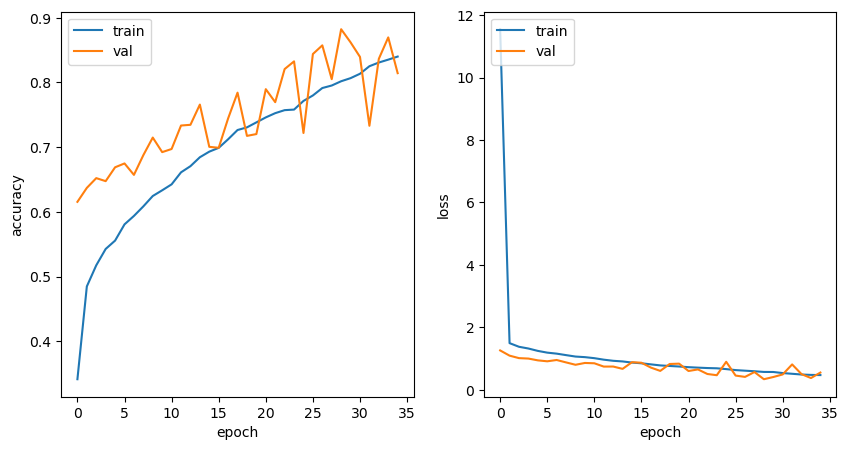

In [63]:
plot_history(efficientnet_v2_model_history)

In [64]:
efficientnet_v2_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = {v: k for k,v in class_indices.items()}

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=True, #False
)

predictions = efficientnet_v2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/tmp/ipykernel_22/1110887102.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = efficientnet_v2_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.09833333333333333
Global F2 Score: 0.09833333333333333


,Precision,Recall,F-Score,Support
AnnualCrop,0.102625,0.143333,0.119611,600.0
Forest,0.097152,0.096667,0.096909,600.0
HerbaceousVegetation,0.108317,0.093333,0.100269,600.0
Highway,0.116147,0.082000,0.096131,500.0
Industrial,0.093306,0.092000,0.092649,500.0
Pasture,0.075294,0.080000,0.077576,400.0
PermanentCrop,0.091255,0.096000,0.093567,500.0
Residential,0.096866,0.113333,0.104455,600.0
River,0.087071,0.066000,0.075085,500.0
SeaLake,0.110526,0.105000,0.107692,600.0


In [65]:
# Save the model and the weights
efficientnet_v2_model.save('../working/efficientnet_v2.h5')

/tmp/ipykernel_22/3683959286.py:156: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


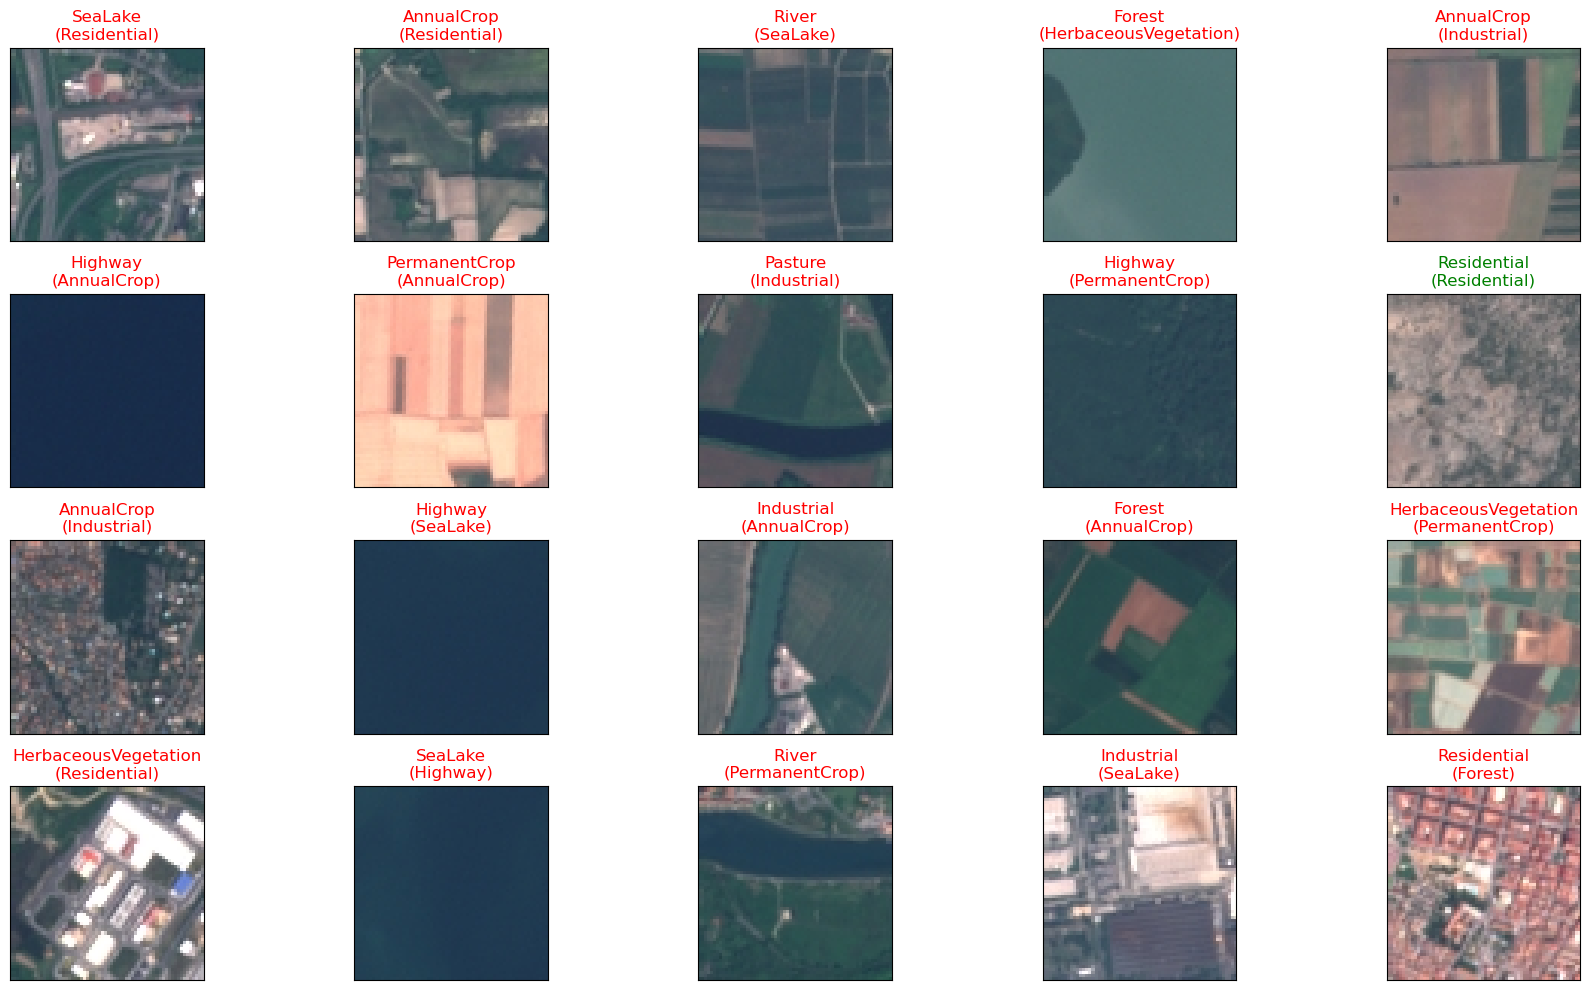

In [66]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)

## 4.7 DenseNet Model

In [67]:
gc.collect()

DenseNet_model = compile_model('DenseNet', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-2), fine_tune=None)
#DenseNet_model.summary()

/opt/conda/lib/python3.10/site-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


74836368/74836368 [==============================] - 4s 0us/step


In [68]:
train_generator.reset()
test_generator.reset()

N_STEPS = train_generator.samples//BATCH_SIZE
N_VAL_STEPS = test_generator.samples//BATCH_SIZE

# model callbacks
checkpoint = ModelCheckpoint(filepath='../working/model.weights.best.hdf5',
                        monitor='val_categorical_accuracy',
                        save_best_only=True,
                        verbose=1)

early_stop = EarlyStopping(monitor='val_categorical_accuracy',
                           patience=10,
                           restore_best_weights=True,
                           mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5,
                              patience=3, min_lr=0.00001)

In [69]:
%%time

train_generator.reset()
# First Pretraining the dense layer
efficientnet_history = DenseNet_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


<timed exec>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


337/337 [==============================] - ETA: 0s - loss: 4.4742 - categorical_accuracy: 0.5410
Epoch 1: val_categorical_accuracy improved from -inf to 0.73270, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 64s 152ms/step - loss: 4.4742 - categorical_accuracy: 0.5410 - val_loss: 0.8306 - val_categorical_accuracy: 0.7327
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 1.1113 - categorical_accuracy: 0.6240
Epoch 2: val_categorical_accuracy did not improve from 0.73270
337/337 [==============================] - 45s 133ms/step - loss: 1.1113 - categorical_accuracy: 0.6240 - val_loss: 0.8441 - val_categorical_accuracy: 0.7161
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 1.1335 - categorical_accuracy: 0.6207
Epoch 3: val_categorical_accuracy improved from 0.73270 to 0.78013, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 52s 154ms/step - loss: 1.1335 

In [70]:
# re-train whole network end2end 
DenseNet_model = compile_model('DenseNet', INPUT_SHAPE, NUM_CLASSES, Adam(lr=1e-4), fine_tune=0)

DenseNet_model.load_weights('../working/model.weights.best.hdf5')

train_generator.reset()
test_generator.reset()

DenseNet_history = DenseNet_model.fit_generator(train_generator,
                             steps_per_epoch=N_STEPS,
                             epochs=N_EPOCHS,
                             callbacks=[early_stop, checkpoint, reduce_lr],
                             validation_data=test_generator,
                             validation_steps=N_VAL_STEPS,workers=-1,
                            use_multiprocessing=True,)

Epoch 1/35


/tmp/ipykernel_22/2959541682.py:9: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  DenseNet_history = DenseNet_model.fit_generator(train_generator,


337/337 [==============================] - ETA: 0s - loss: 1.3610 - categorical_accuracy: 0.5695
Epoch 1: val_categorical_accuracy did not improve from 0.81678
337/337 [==============================] - 83s 179ms/step - loss: 1.3610 - categorical_accuracy: 0.5695 - val_loss: 0.7988 - val_categorical_accuracy: 0.8045 - lr: 1.0000e-04
Epoch 2/35
337/337 [==============================] - ETA: 0s - loss: 0.8502 - categorical_accuracy: 0.7347
Epoch 2: val_categorical_accuracy improved from 0.81678 to 0.92653, saving model to ../working/model.weights.best.hdf5
337/337 [==============================] - 66s 195ms/step - loss: 0.8502 - categorical_accuracy: 0.7347 - val_loss: 0.2953 - val_categorical_accuracy: 0.9265 - lr: 1.0000e-04
Epoch 3/35
337/337 [==============================] - ETA: 0s - loss: 0.6787 - categorical_accuracy: 0.7832
Epoch 3: val_categorical_accuracy improved from 0.92653 to 0.93341, saving model to ../working/model.weights.best.hdf5
337/337 [===========================

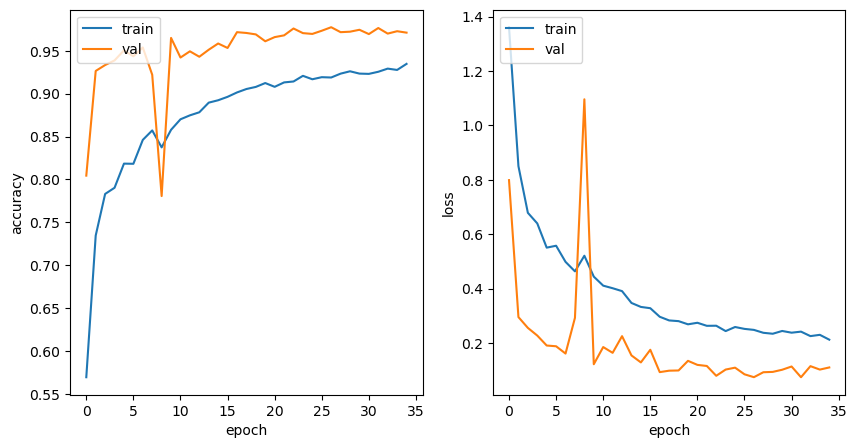

In [71]:
plot_history(DenseNet_history)

In [72]:
DenseNet_model.load_weights('../working/model.weights.best.hdf5')

class_indices = train_generator.class_indices
class_indices = {v: k for k,v in class_indices.items()}

test_generator_new = test_gen.flow_from_directory(
    directory=TEST_DIR,
    target_size=(64, 64),
    batch_size=1,
    class_mode=None,
    color_mode='rgb',
    shuffle=True, #False
)

predictions = DenseNet_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))
predicted_classes = np.argmax(np.rint(predictions), axis=1)
true_classes = test_generator_new.classes

prf, conf_mat = display_results(true_classes, predicted_classes, class_indices.values())
prf

Found 5400 images belonging to 10 classes.


/tmp/ipykernel_22/2586819754.py:15: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = DenseNet_model.predict_generator(test_generator_new, steps=len(test_generator_new.filenames))


Accuracy: 0.1087037037037037
Global F2 Score: 0.1087037037037037


,Precision,Recall,F-Score,Support
AnnualCrop,0.117450,0.116667,0.117057,600.0
Forest,0.125612,0.128333,0.126958,600.0
HerbaceousVegetation,0.130148,0.131667,0.130903,600.0
Highway,0.112224,0.112000,0.112112,500.0
Industrial,0.095723,0.094000,0.094854,500.0
Pasture,0.069588,0.067500,0.068528,400.0
PermanentCrop,0.095050,0.096000,0.095522,500.0
Residential,0.096880,0.098333,0.097601,600.0
River,0.110442,0.110000,0.110220,500.0
SeaLake,0.116162,0.115000,0.115578,600.0


In [73]:
# Save the model and the weights
DenseNet_model.save('../working/DenseNet.h5')

/tmp/ipykernel_22/3683959286.py:156: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


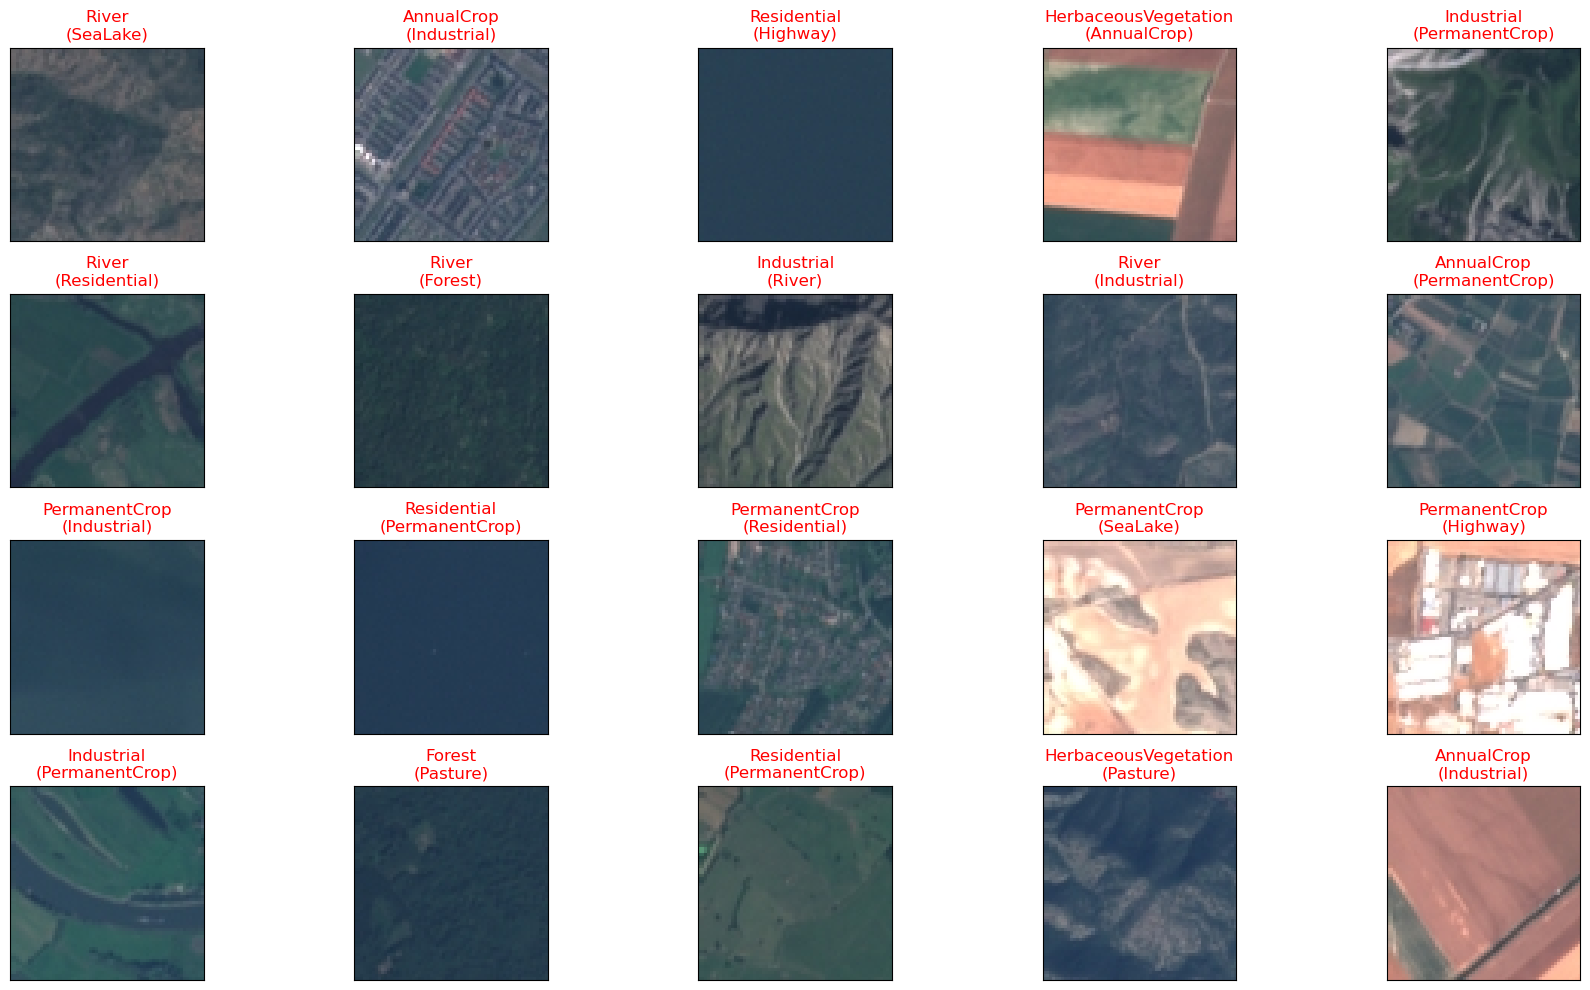

In [74]:
plot_predictions(true_classes, predictions, test_generator_new, class_indices)